# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [3]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")



## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [4]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [5]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

2022-09-21 11:06:21.828387: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-21 11:06:21.829316: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-21 11:06:21.864983: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 11:06:21.865298: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro P620 computeCapability: 6.1
coreClock: 1.4425GHz coreCount: 4 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 89.53GiB/s
2022-09-21 11:06:21.865374: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directo

Instructions for updating:
box_ind is deprecated, use box_indices instead
Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
Use `tf.cast` instead.


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [6]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

Processing 1 images
image                    shape: (425, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


2022-09-21 11:06:38.192400: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-21 11:06:38.209283: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


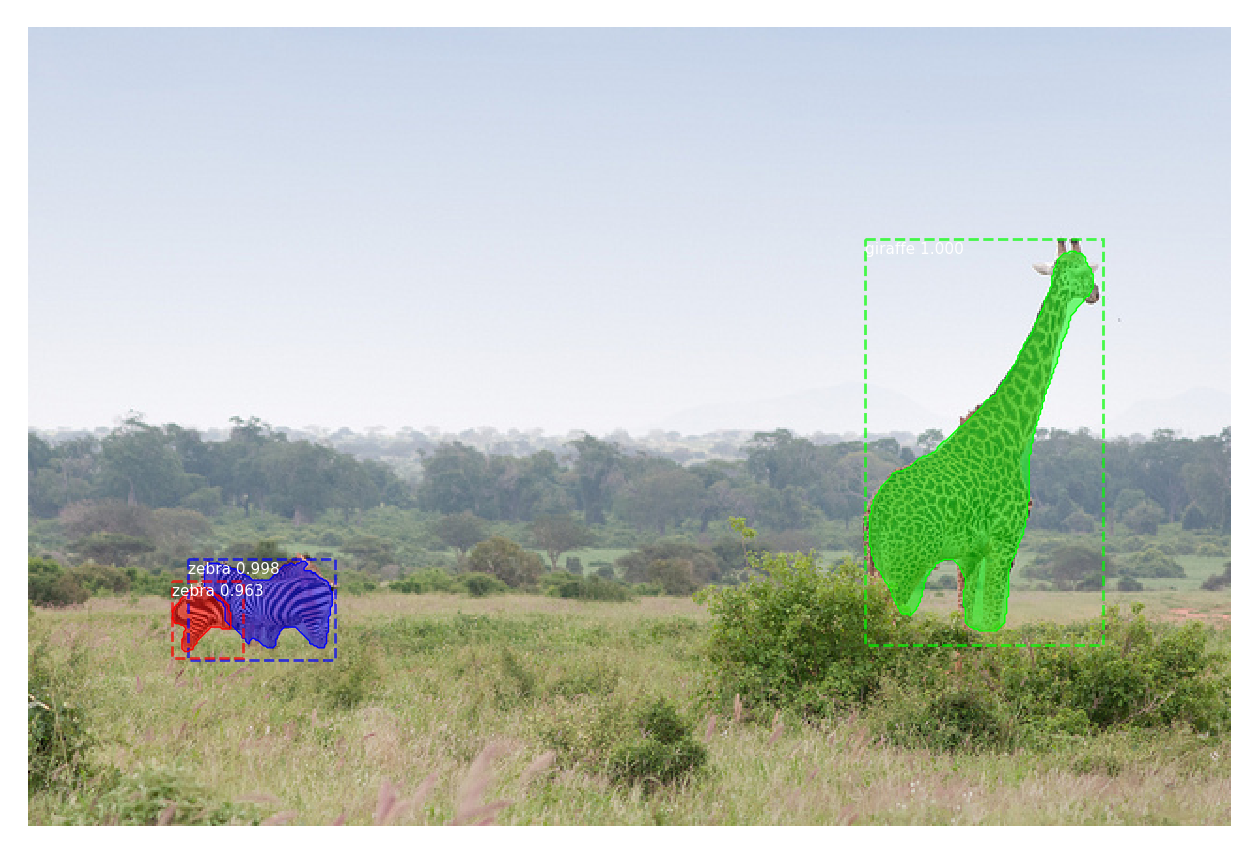

In [7]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])


In [44]:
import cv2

RGB_input_DIR = '/home/natanan/ImageLeftCam1'
Depth_input_DIR = '/home/natanan/DepthLeftCam1'
RGB_output_DIR = '/home/natanan/test_color_duration'
Depth_output_DIR = '/home/natanan/test_depth_duration'

# All_duration = [[each duration of fisrt image],[],...,[each duration of last image]]
# Each_duation = [duration_read_color, duration_read_depth, duation_seg, duration_save_color, duration_save_depth, duration_process]

def save_images_from_path_folder(RGB_input_DIR, Depth_input_DIR, RGB_output_DIR, Depth_output_DIR):
    s = 0
    All_duation = [] # save all processing duation
    for filename in os.listdir(RGB_input_DIR):
        Each_duration = [] # save each processing duation

        # time start processing
        time_start_process = cv2.getTickCount()

        # time duration read color image
        time_start_read_color = cv2.getTickCount() # start time read color image
        image = cv2.imread(os.path.join(RGB_input_DIR+'/'+os.listdir(RGB_input_DIR)[s]), cv2.IMREAD_UNCHANGED)
        # image = cv2.resize(image,(640,480))
        time_stop_read_color = cv2.getTickCount() # stop time read color image
        duration_read_color = (time_stop_read_color - time_start_read_color)/cv2.getTickFrequency() # time duration read color image 
        Each_duration.append(duration_read_color)

        # time duration read depth image
        time_start_read_depth = cv2.getTickCount() # start time read depth image
        depth = cv2.imread(os.path.join(Depth_input_DIR+'/'+os.listdir(Depth_input_DIR)[s]),cv2.IMREAD_UNCHANGED)
        # depth = cv2.resize(image,(640,480))
        time_stop_read_depth = cv2.getTickCount() # stop time read depth image
        duration_read_depth = (time_stop_read_depth - time_start_read_depth)/cv2.getTickFrequency() # time duration read depth image 
        Each_duration.append(duration_read_depth)

        time_start_seg = cv2.getTickCount() # start time segmentation
        results = model.detect([image], verbose=1)
        r = results[0]
        indices_to_remove  = np.where((r['class_ids'] != 1) & (r['class_ids'] != 3)) #output index
        new_class_ids = np.delete(r['class_ids'], indices_to_remove, axis=0)
        new_rois = np.delete(r['rois'], indices_to_remove, axis=0)
        new_scores = np.delete(r['scores'], indices_to_remove, axis=0)
        new_masks = np.delete(r['masks'], indices_to_remove, axis=2)
        y_image_axis = new_masks.shape[0]
        x_image_axis = new_masks.shape[1]
        All_instance = new_masks.shape[2]
        image_rgba = cv2.cvtColor(image,cv2.COLOR_RGB2RGBA)

        if All_instance > 0:
            for i in range(y_image_axis): #y-axis
                for j in range(x_image_axis): #x-axis
                    for k in range(All_instance):
                        if new_masks[i,j,k] == True: #i - vertical , j - horizontal
                            image_rgba[i,j,3] = 0
                            depth[i,j] = 0
            check = 1
        else : 
            print('No require instance')
            check = 0
        
        time_stop_seg = cv2.getTickCount() # stop time segmentation
        duration_seg = (time_stop_seg - time_start_seg)/cv2.getTickFrequency() # time duration save color image 
        Each_duration.append(duration_seg)

        # time duration save color image
        time_start_save_color = cv2.getTickCount() # start time save color image
        rgb_out = os.path.join(RGB_output_DIR+'/'+os.listdir(RGB_input_DIR)[s][0:len(os.listdir(RGB_input_DIR)[s])-4])+'.png' #filename[0:len(filename)-4] to remove .jpg
        # rgb_out = os.path.join(RGB_output_DIR+'/'+str(s))+'.png' #filename[0:len(filename)-4] to remove .jpg
        cv2.imwrite(rgb_out,image_rgba)
        time_stop_save_color = cv2.getTickCount() # stop time save depth image
        duration_save_color = (time_stop_save_color - time_start_save_color)/cv2.getTickFrequency() # time duration save color image 
        Each_duration.append(duration_save_color)

        # time duration save color image
        time_start_save_depth = cv2.getTickCount() # start time save color image
        depth_out = os.path.join(Depth_output_DIR+'/'+os.listdir(Depth_input_DIR)[s][0:len(os.listdir(Depth_input_DIR)[s])-4])+'.png'
        # depth_out = os.path.join(Depth_output_DIR+'/'+str(s))+'.png'        
        cv2.imwrite(depth_out,depth)
        time_stop_save_depth = cv2.getTickCount() # stop time save depth image
        duration_save_depth = (time_stop_save_depth - time_start_save_depth)/cv2.getTickFrequency() # time duration save color image
        Each_duration.append(duration_save_depth)

        s  = s + 1

        # time stop processing
        time_stop_process = cv2.getTickCount()

        # time duration processing
        duration_process = (time_stop_process - time_start_process)/cv2.getTickFrequency()
        Each_duration.append(duration_process)

        # save all duration
        All_duation.append(Each_duration)

    return  All_duation #rgb_out, depth_out


# img = cv2.imread(os.path.join('/media/natanan/CITYSCAPE/testrtab/depth'+'/'+ 'depth_1.png'), cv2.IMREAD_UNCHANGED)
# print(img.dtype)

# image_rgba, depth_gray = save_images_from_path_folder(RGB_input_DIR, Depth_input_DIR, RGB_output_DIR, Depth_output_DIR)

All_time_process = save_images_from_path_folder(RGB_input_DIR, Depth_input_DIR, RGB_output_DIR, Depth_output_DIR)



Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
No require instance
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
No require instance
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 

In [45]:
# Each_duation = [duration_read_color, duration_read_depth, duration_seg, duration_save_color, duration_save_depth, duration_process]
print(All_time_process)

def ave_duration(All_time_process):
    sum_read_color = 0
    sum_read_depth = 0
    sum_seg = 0
    sum_save_color = 0
    sum_save_depth = 0
    sum_process = 0

    for i in range(len(All_time_process)):
        sum_read_color += All_time_process[i][0]
        sum_read_depth += All_time_process[i][1]
        sum_seg += All_time_process[i][2]
        sum_save_color += All_time_process[i][3]
        sum_save_depth += All_time_process[i][4]
        sum_process += All_time_process[i][5]

    ave_read_color = sum_read_color/len(All_time_process)
    ave_read_depth = sum_read_depth/len(All_time_process)
    ave_seg = sum_seg/len(All_time_process)
    ave_save_color = sum_save_color/len(All_time_process)
    ave_save_depth = sum_save_depth/len(All_time_process)
    ave_process = sum_process/len(All_time_process)
    return ave_read_color, ave_read_depth, ave_seg, ave_save_color, ave_save_depth, ave_process

print(ave_duration(All_time_process))


[[0.016904855, 0.007915818, 2.532712331, 0.048088132, 0.013231821, 2.618876982], [0.016223998, 0.008225042, 2.496152041, 0.047277135, 0.014470344, 2.582367873], [0.01589154, 0.007608196, 3.452236318, 0.046164187, 0.013648322, 3.535571916], [0.015608915, 0.007532925, 3.425389794, 0.045538896, 0.01335073, 3.507441798], [0.01545071, 0.00991472, 2.440808351, 0.048015779, 0.018572348, 2.532782225], [0.016040693, 0.010408422, 2.481063407, 0.056258562, 0.021482848, 2.58527727], [0.016091093, 0.010333541, 2.479947264, 0.047981431, 0.018738168, 2.573110763], [0.015549904, 0.010545789, 2.510236873, 0.048704666, 0.020408384, 2.605661628], [0.016271045, 0.008002384, 2.545654833, 0.054099972, 0.015508861, 2.639725841], [0.016670738, 0.009477854, 2.487135143, 0.053540145, 0.018008882, 2.585108], [0.015971524, 0.010265545, 2.466012452, 0.045151122, 0.01659645, 2.554019298], [0.015337205, 0.007670181, 2.490191664, 0.076893145, 0.013012865, 2.603124222], [0.016247487, 0.008934569, 2.662010716, 0.062500